# Подготовка датасета

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn

# открываем колабу доступ к гугл-диску, чтобы загрузить датасет
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# читаем файл, выводим переменные
path = "/content/drive/My Drive/Colab Notebooks/weatherAUS.csv"
data = pd.read_csv(path)
data.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RISK_MM', 'RainTomorrow'],
      dtype='object')

In [ ]:
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


Описание переменных датасета:
* Date - дата наблюдений
* Location - локация, в которой расположена метеорологическая станция
* MinTemp - минимальная температура (℃)
* MaxTemp - максимальная температура (℃)
* Rainfall - количество осадков, зафиксированных за день (мм)
* Evaporation - "pan evaporation" класса А (мм) за 24 часа до 9 утра
* Sunshine - число солнечных часов за день
* WindGustDir - направление самого сильного порыва ветра за последние 24 часа
* WindGustSpeed - скорость самого сильного порыва ветра за последние 24 часа (км/ч)
* WindDir9am - направление ветра в 9 часов утра
* WindDir3pm - направление ветра в 3 часа ночи
* WindSpeed9am - скорость ветра в 9 часов утра (км/ч)
* WindSpeed3pm - скорость ветра в 3 часа ночи (км/ч)
* Humidity9am - влажность воздуха в 9 часов утра (%)
* Humidity3pm - влажность воздуха в 3 часа ночи (%)
* Pressure9am - давление в 9 часов утра (hPa)
* Pressure3pm - давление в 3 часа ночи (hPa)
* Cloud9am - облачность в 9 часов утра (oktas)
* Cloud3pm - облачность в 3 часа ночи (oktas)
* Temp9am - температура в 9 часов утра (℃)
* Temp3pm - температура в 3 часа ночи (℃)
* RainToday - есть ли сегодня дождь
* RISK_MM - мера риска возникновения дождя на следующий день (мм)
* RainTomorrow - будет ли завтра дождь (целевая переменная)

Переменная RISK_MM используется для создания целевой переменной (если RISK_MM < 1 мм, считаем, что дождя не будет). Удалим этот столбец из датасета (как это указано в исходнике задания на kaggle), так как по факту по нему и рассчитывают таргет синоптики, а значит, с его использованием точность предсказаний будет завышена (проверено экспериментально).

In [ ]:
data = data.drop('RISK_MM', axis=1)

Далее нам нужно привести все номинальные признаки в порядковые.

In [ ]:
# приведём значения столбца Date ко дню года
data['Date'] = pd.to_datetime(data['Date'])
data['Date'] = data['Date'].dt.dayofyear

# заменяем значения столбца Location
# сделал через tranform, дальше буду через более короткий map
temp_dict = dict(zip(data['Location'].dropna().unique().tolist(), range(len(data['Location'].dropna().unique().tolist()))))
data['Location'] = data['Location'].transform(lambda x: temp_dict.get(x))

# совместно обрабатываем WindGustDir, WindDir9am, WindDir3pm
temp_dict = dict(zip(data['WindGustDir'].dropna().unique().tolist(), range(len(data['WindGustDir'].dropna().unique().tolist()))))
data['WindGustDir'] = data['WindGustDir'].map(temp_dict)
data['WindDir9am'] = data['WindDir9am'].map(temp_dict)
data['WindDir3pm'] = data['WindDir3pm'].map(temp_dict)

In [ ]:
# проверяем количество ненулевых объектов в датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  int64  
 1   Location       142193 non-null  int64  
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  float64
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  float64
 10  WindDir3pm     138415 non-null  float64
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17  Cloud9am       88536 non-null

Как мы можем видеть, RainToday содержит пропуски данных. Мы не можем заменить их медианными или средними значениями, так как это данные бинарного типа. Кроме того, RainToday может сильно влиять на таргет. Так как пропусков немного (< 1%), самым простым выходом из ситуации будет удаление строк с пропусками в RainToday.

In [ ]:
data = data[data.RainToday.notnull()]

# обновляем индексы строк датасета
data = data.reset_index(drop=True)

# выводим уникальные значения RainToday (такие же у RainTomorrow)
data['RainToday'].unique().tolist()

['No', 'Yes']

In [ ]:
# вручную заменяем значения RainToday и RainTommorow
data['RainToday'] = data['RainToday'].map({'No': False, 'Yes': True}).astype(bool)
data['RainTomorrow'] = data['RainTomorrow'].map({'No': False, 'Yes': True}).astype(bool)

In [ ]:
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,336,0,13.4,22.9,0.6,NaN,NaN,0.0,44.0,0.0,1.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,False,False
1,337,0,7.4,25.1,0.0,NaN,NaN,1.0,44.0,4.0,2.0,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,False,False
2,338,0,12.9,25.7,0.0,NaN,NaN,2.0,46.0,0.0,2.0,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,False,False
3,339,0,9.2,28.0,0.0,NaN,NaN,3.0,24.0,12.0,14.0,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,False,False
4,340,0,17.5,32.3,1.0,NaN,NaN,0.0,41.0,8.0,11.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,False,False


Теперь все номинальные признаки приведены к порядковым.

Заполним оставшиеся пропуски в данных на медианные значения по столбцам. Так как в дальнейшем мы будем делить выборку на train и test, лучше всего сначала совершить разделение, а потом отдельно заполнить пропуски в обеих частях.

In [ ]:
# разбиваем выборку на train и test
from sklearn.model_selection import train_test_split
Y = data['RainTomorrow']
X = data.iloc[:,:data.shape[1]-1]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, shuffle=False)

# заменяем все NaN на медианные значения столбцов
x_train = x_train.apply(lambda x: x.fillna(x.median()))
x_test = x_test.apply(lambda x: x.fillna(x.median()))

На этом этап предобработки датасета можем считать завершённым, переходим к подбору и обучению моделей.

# Наивный Байесовский классификатор

Используем для предсказания наивный Байесовский классификатор. Из нескольких байесов в sklearn выбираем GaussianNB, так как остальные не работают с нашим датасетом (либо выдают ValueError, либо работают неправильно, как BernoulliNB, рассчитанный на бинарные фичи).

In [ ]:
from sklearn.naive_bayes import GaussianNB
bayes = GaussianNB()
bayes.fit(x_train, y_train)
prediction = bayes.predict(x_test)

Проведём оценку качества модели различными метриками бинарной классификации. Для начала построим матрицу неточностей:

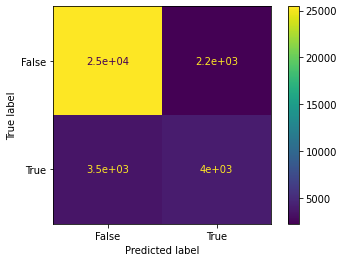

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(bayes, x_test, y_test) 
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
scores_bayes = [accuracy_score(y_test, prediction)]
accuracy_score(y_test, prediction)

0.8360655737704918

In [ ]:
# полнота
scores_bayes.append(recall_score(y_test, prediction))
recall_score(y_test, prediction)

0.5304139491547983

In [ ]:
# точность
scores_bayes.append(precision_score(y_test, prediction))
precision_score(y_test, prediction)

0.6399550345270596

In [ ]:
scores_bayes.append(f1_score(y_test, prediction))
f1_score(y_test, prediction)

0.5800582241630275

In [ ]:
scores_bayes.append(roc_auc_score(y_test, prediction))
roc_auc_score(y_test, prediction)

0.7247142712108336

Точность предсказания можно повысить, если поработать с признаками. Для этого найдём коэффициенты корреляции признаков:

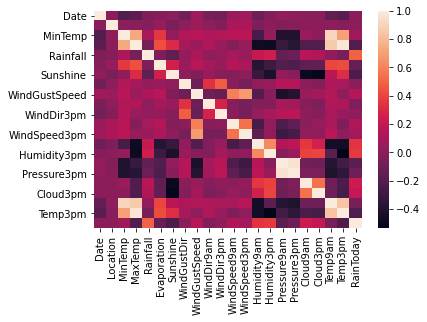

In [ ]:
# строим тепловую карту для обнаружения коррелирующих признаков
import seaborn as sns
sns.heatmap(x_train.corr())

Далее была проведена попытка дропнуть коррелирующие фичи из x_train и x_test:
1. удалены Temp9am, Temp3pm, Cloud9am; получено:
accuracy 0.837, recall 0.517, precision 0.647, f1 0.575, AUC 0.72
2. удалены WindDir9am, WindSpeed9am, Temp9am, Humidity9am, Pressure9am, Cloud9am; получено:
accuracy 0.834, recall 0.492, precision 0.646, f1 0.559, AUC 0.71

Вывод: оставляем признаки как есть (без дропа показатели выше).

In [ ]:
# блок, который дропает фичи
x_train = x_train.drop(['WindDir9am','WindSpeed9am','Temp9am','Humidity9am','Pressure9am','Cloud9am'], axis=1)
x_test = x_test.drop(['WindDir9am','WindSpeed9am','Temp9am','Humidity9am','Pressure9am','Cloud9am'], axis=1)
bayes.fit(x_train, y_train)
prediction = bayes.predict(x_test)

# Метод ближайших соседей

Используем для предсказания метод ближайших соседей. Попробуем варьировать количество соседей для улучшения качества работы модели. Так как для задачи с двумя классами берут нечётное число соседей во избежание неоднозначностей, будем ранжировать число соседей с шагом в 2.

In [ ]:
%%time
from sklearn.neighbors import KNeighborsClassifier
f1_var = []
auc_var = []
n_nb = range(1, 12, 2)
for i in n_nb:
  neighbor = KNeighborsClassifier(n_neighbors=i)
  neighbor.fit(x_train, y_train)
  prediction = neighbor.predict(x_test)
  f1_var.append((f1_score(y_test, prediction)))
  auc_var.append((roc_auc_score(y_test, prediction)))

In [ ]:
# строим графики зависимости метрик от числа соседей
plt.figure()
plt.xlabel("n_neighbors")
plt.ylabel("score")
plt.title("Score on KNeighborsClassifier")
plt.plot(n_nb, f1_var, color = "blue", label = "f1_score")
plt.plot(n_nb, auc_var, color = "red", label = "roc_auc_score")
plt.legend()

Наилучшие показатели метрик были получены при количестве соседей 7, рассчитаем для них все метрики:

In [ ]:
neighbor = KNeighborsClassifier(n_neighbors=7)
neighbor.fit(x_train, y_train)
prediction = neighbor.predict(x_test)

# матрица неточностей
plot_confusion_matrix(neighbor, x_test, y_test)
plt.show()

In [ ]:
scores_neighbor = [accuracy_score(y_test, prediction)]
accuracy_score(y_test, prediction)

In [ ]:
# полнота
scores_neighbor.append(recall_score(y_test, prediction))
recall_score(y_test, prediction)

In [ ]:
# точность
scores_neighbor.append(precision_score(y_test, prediction))
precision_score(y_test, prediction)

In [ ]:
scores_neighbor.append(f1_score(y_test, prediction))
f1_score(y_test, prediction)

In [ ]:
scores_neighbor.append(roc_auc_score(y_test, prediction))
roc_auc_score(y_test, prediction)

# Логистическая регрессия

Используем для предсказания логистическую регрессию. Так как данные не были нормированы, нет смысла проводить регуляризацию (+ пытался её провести, но результаты не изменились). max_iter подбираем эмпирически (на default выдаёт ошибку в связи с недостаточностью).

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter = 1000)
log_reg.fit(x_train, y_train)
prediction = log_reg.predict(x_test)

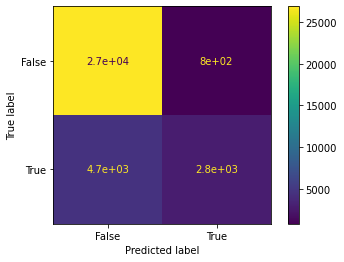

In [ ]:
# матрица неточностей
plot_confusion_matrix(log_reg, x_test, y_test)
plt.show()

In [ ]:
scores_log_reg = [accuracy_score(y_test, prediction)]
accuracy_score(y_test, prediction)

0.8446742620109668

In [ ]:
# полнота
scores_log_reg.append(recall_score(y_test, prediction))
recall_score(y_test, prediction)

0.3785438573139891

In [ ]:
# точность
scores_log_reg.append(precision_score(y_test, prediction))
precision_score(y_test, prediction)

0.7808896210873146

In [ ]:
scores_log_reg.append(f1_score(y_test, prediction))
f1_score(y_test, prediction)

0.5099058718063648

In [ ]:
scores_log_reg.append(roc_auc_score(y_test, prediction))
roc_auc_score(y_test, prediction)

0.6748592715265221

# Вывод

Сравним показатели метрик всех применённых моделей:

In [ ]:
res_arr = np.array([scores_bayes, scores_neighbor, scores_log_reg])
res = pd.DataFrame(res_arr, columns = ['accuracy', 'recall', 'precision', 'f1_score', 'roc_auc_score'], index = ['NaiveBayes', 'KNeighbors', 'LogisticRegression'])
res

,accuracy,recall,precision,f1_score,roc_auc_score
NaiveBayes,0.836066,0.530414,0.639955,0.580058,0.724714
KNeighbors,0.844277,0.453614,0.712375,0.554282,0.701955
LogisticRegression,0.844674,0.378544,0.780890,0.509906,0.674859


Как видно из таблицы, Байес показал наилучший результат в предсказании. Хотя он значительно уступает в precision, по recall и по общим оценкам (f1, AUC) он впереди. В принципе, с учётом специфики решаемой задачи recall, пожалуй, важнее, чем precison (так как false negative в случае наличия дождя приведёт к тому, что человек промокнет, а false positive всего лишь заставит зря носить весь день зонт).

Исходя из вышесказанного, можно подытожить, что из трёх предложенных моделей Байес лучше всего подходит для решения исходной задачи.

Что можно было сделать помимо этого? Во-первых, получше провести селекцию признаков (настораживает, что при дропе очевидно коррелирующих признаков качество работы модели ухудшается). Во-вторых, можно было бы провести нормализацию данных и улучшить работу логистической регрессии регуляризацией. В-третьих, не лишним было бы провести кросс-валидацию.